In [2]:
import pandas as pd

df = pd.read_csv('Data/data.csv')
df.head()

C:\Users\ryana\AppData\Local\Temp\ipykernel_9464\2155276850.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/data.csv')


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [3]:
# #filter the df to where anything that doesn't have a latitude and langitude are dropped

# df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])
# #Also remove any where latitude or longitude are 0
# df = df[(df['LATITUDE'] != 0) & (df['LONGITUDE'] != 0)]

In [4]:
# df = df[:200]

In [5]:
# #print the df latitude and longitude pairs
# for index, row in df.iterrows():
#     print(f"Latitude: {row['LATITUDE']}, Longitude: {row['LONGITUDE']}")


In [6]:
# import geopandas as gpd
# import folium
# from folium.plugins import MarkerCluster

# # Define NYC map center coordinates
# nyc_coords = [40.7128, -74.0060]

# # Create a Folium map with base tiles and a satellite layer
# m = folium.Map(location=nyc_coords, zoom_start=12, control_scale=True)
# folium.TileLayer('cartodbpositron', name='Base Map').add_to(m)
# folium.TileLayer('cartodb dark_matter', name='Satellite').add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)

# # Add crash markers using MarkerCluster
# marker_cluster = MarkerCluster().add_to(m)
# for _, row in df.iterrows():
#     if -74.05 <= row['LONGITUDE'] <= -73.75 and 40.55 <= row['LATITUDE'] <= 40.90:  # Ensure coordinates are within NYC

#         folium.CircleMarker(
#             location=[row['LATITUDE'], row['LONGITUDE']],
#             radius=8,
#             color='red',
#             fill=True,
#             fill_color='red',
#             fill_opacity=1.0,
#             weight=2
#         ).add_to(marker_cluster)
#         print(f"Added marker for coordinates: Latitude: {row['LATITUDE']}, Longitude: {row['LONGITUDE']}")
#     else:
#         print(f"Skipping out-of-bounds coordinates: Latitude: {row['LATITUDE']}, Longitude: {row['LONGITUDE']}")

# # Display the map
# m


In [7]:
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155068,02/08/2025,0:00,BRONX,10466.0,40.888740,-73.837320,"(40.88874, -73.83732)",E 233 ST,MONTICELLO AVE,NaN,...,Unspecified,NaN,NaN,NaN,4791391,Sedan,Sedan,NaN,NaN,NaN
2155069,02/05/2025,9:00,QUEENS,11356.0,40.784554,-73.855010,"(40.784554, -73.85501)",14 RD,112 ST,NaN,...,Unspecified,NaN,NaN,NaN,4791771,Sedan,NaN,NaN,NaN,NaN
2155070,02/08/2025,8:50,BROOKLYN,11212.0,40.657120,-73.915990,"(40.65712, -73.91599)",NaN,NaN,450 ROCKAWAY PKWY,...,NaN,NaN,NaN,NaN,4791787,Sedan,NaN,NaN,NaN,NaN
2155071,02/08/2025,23:15,NaN,NaN,40.650635,-73.732140,"(40.650635, -73.73214)",CRAFT AVE,257 ST,NaN,...,Unspecified,NaN,NaN,NaN,4791816,Sedan,Pick-up Truck,NaN,NaN,NaN


In [8]:
#Make sure CRASH DATE is a datetime

df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
#Filter out any rows that don't have a crash date
df = df.dropna(subset=['CRASH DATE'])
df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3           

Most popular crash date: 2014-01-21 00:00:00 with 1161 crashes.


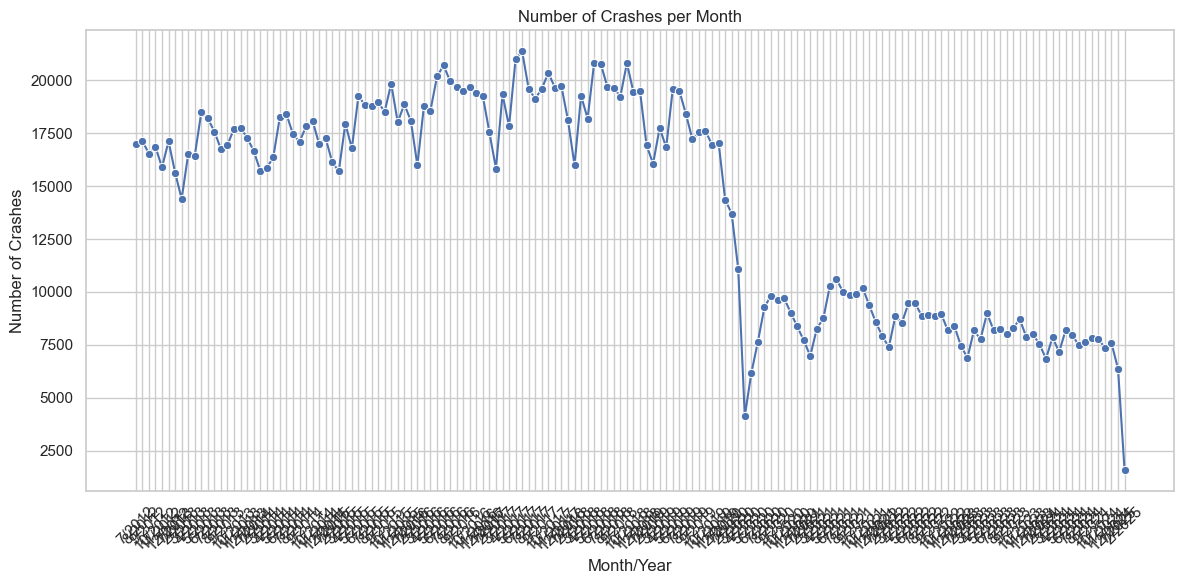

In [9]:
#Print the MOST POPULAR CRASH DATE and number of crashes on that date
most_popular_date = df['CRASH DATE'].mode()[0]
most_popular_date_count = df['CRASH DATE'].value_counts().max()
print(f"Most popular crash date: {most_popular_date} with {most_popular_date_count} crashes.")

#Plot the number of crashes per month (so aggregate by month)
df['CRASH MONTH'] = df['CRASH DATE'].dt.month
df['CRASH YEAR'] = df['CRASH DATE'].dt.year
df['CRASH MONTH YEAR'] = df['CRASH MONTH'].astype(str) + '/' + df['CRASH YEAR'].astype(str)

#Group by month and year
monthly_crashes = df.groupby(['CRASH MONTH', 'CRASH YEAR']).size().reset_index(name='COUNT')
monthly_crashes['CRASH MONTH YEAR'] = monthly_crashes['CRASH MONTH'].astype(str) + '/' + monthly_crashes['CRASH YEAR'].astype(str)
monthly_crashes = monthly_crashes.sort_values(by=['CRASH YEAR', 'CRASH MONTH'])

#Plot the number of crashes per month
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_crashes, x='CRASH MONTH YEAR', y='COUNT', marker='o')
plt.xticks(rotation=45)
plt.title('Number of Crashes per Month')
plt.xlabel('Month/Year')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()



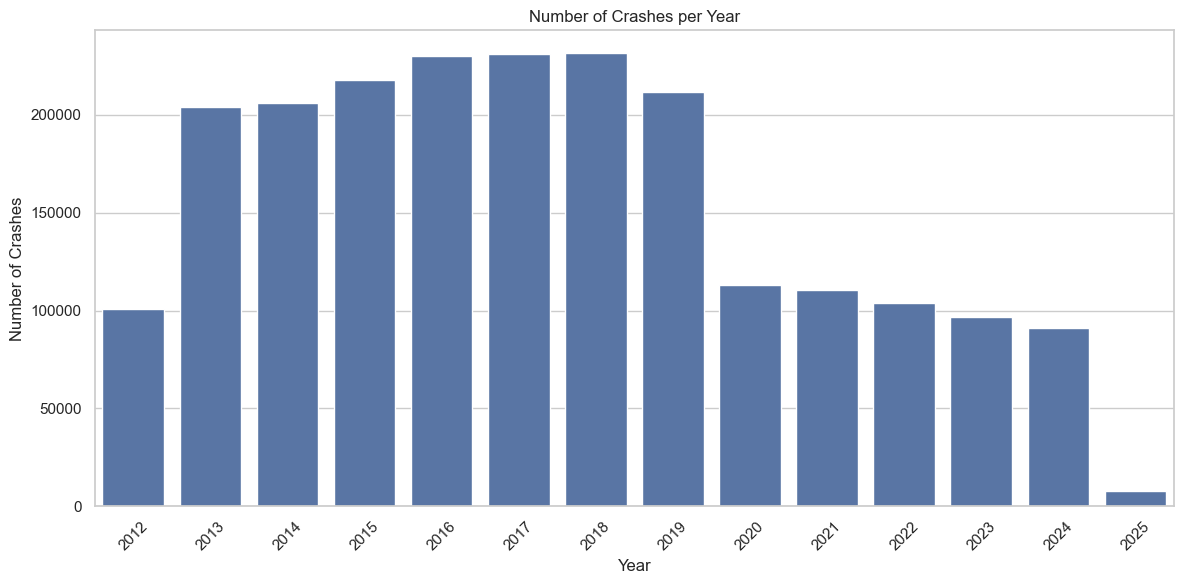

In [10]:
#Do the same thing but by year instead

#Group by year
yearly_crashes = df.groupby(['CRASH YEAR']).size().reset_index(name='COUNT')
yearly_crashes = yearly_crashes.sort_values(by=['CRASH YEAR'])
#Plot the number of crashes per year
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_crashes, x='CRASH YEAR', y='COUNT')
plt.xticks(rotation=45)
plt.title('Number of Crashes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()


In [11]:
#Print most popular type of crash
most_popular_crash_type = df['CONTRIBUTING FACTOR VEHICLE 1'].mode()[0]
most_popular_crash_type_count = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().max()
print(f"Most popular crash type: {most_popular_crash_type} with {most_popular_crash_type_count} crashes.")


Most popular crash type: Unspecified with 726681 crashes.


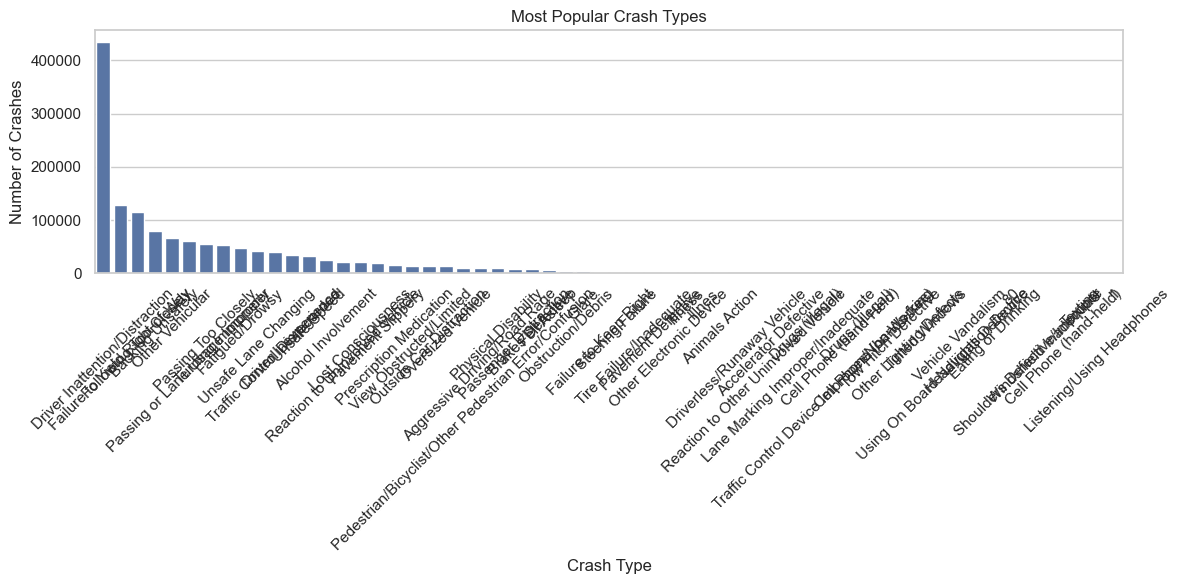

In [12]:
#Plot the most popular crash types
#Group by crash type, ignore "Unspecified"
crash_types = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().reset_index()
crash_types.columns = ['CRASH TYPE', 'COUNT']
crash_types = crash_types[~crash_types['CRASH TYPE'].isin(['Unspecified'])]
crash_types = crash_types.sort_values(by=['COUNT'], ascending=False)
#Plot the most popular crash types
plt.figure(figsize=(12, 6))
sns.barplot(data=crash_types, x='CRASH TYPE', y='COUNT')
plt.xticks(rotation=45)
plt.title('Most Popular Crash Types')
plt.xlabel('Crash Type')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

In [13]:
#Instead of plotting, just sort the crash types by count and print the top 10

crash_types = crash_types.sort_values(by=['COUNT'], ascending=False)
print(crash_types.head(10))

                        CRASH TYPE   COUNT
1   Driver Inattention/Distraction  434676
2    Failure to Yield Right-of-Way  128656
3            Following Too Closely  115575
4                 Backing Unsafely   79083
5                  Other Vehicular   66919
6   Passing or Lane Usage Improper   61111
7              Passing Too Closely   54317
8               Turning Improperly   53087
9                  Fatigued/Drowsy   47475
10            Unsafe Lane Changing   42366


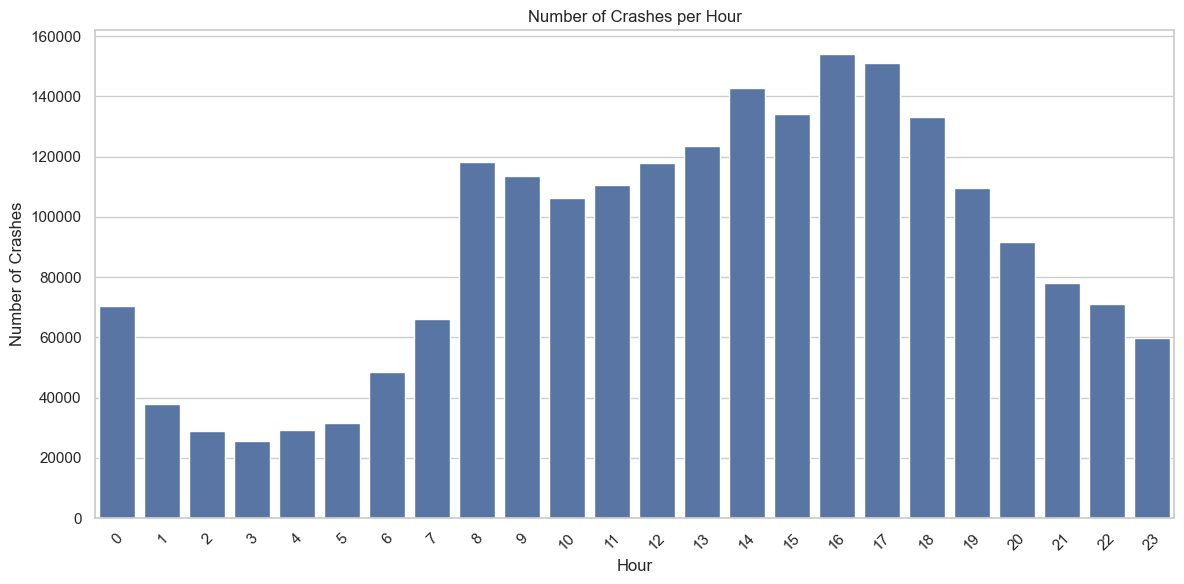

In [14]:
#Plot crashes over the time of day

#Convert CRASH TIME to datetime
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce')
#Filter out any rows that don't have a crash time
df = df.dropna(subset=['CRASH TIME'])
#Extract hour from crash time
df['CRASH HOUR'] = df['CRASH TIME'].dt.hour
#Group by hour
hourly_crashes = df.groupby(['CRASH HOUR']).size().reset_index(name='COUNT')
hourly_crashes = hourly_crashes.sort_values(by=['CRASH HOUR'])
#Plot the number of crashes per hour
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_crashes, x='CRASH HOUR', y='COUNT')
plt.xticks(rotation=45)
plt.title('Number of Crashes per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()